Используйте базу акций Лукойла.

Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Примените абсолютно новый подход. Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).
* Объедините эти точки

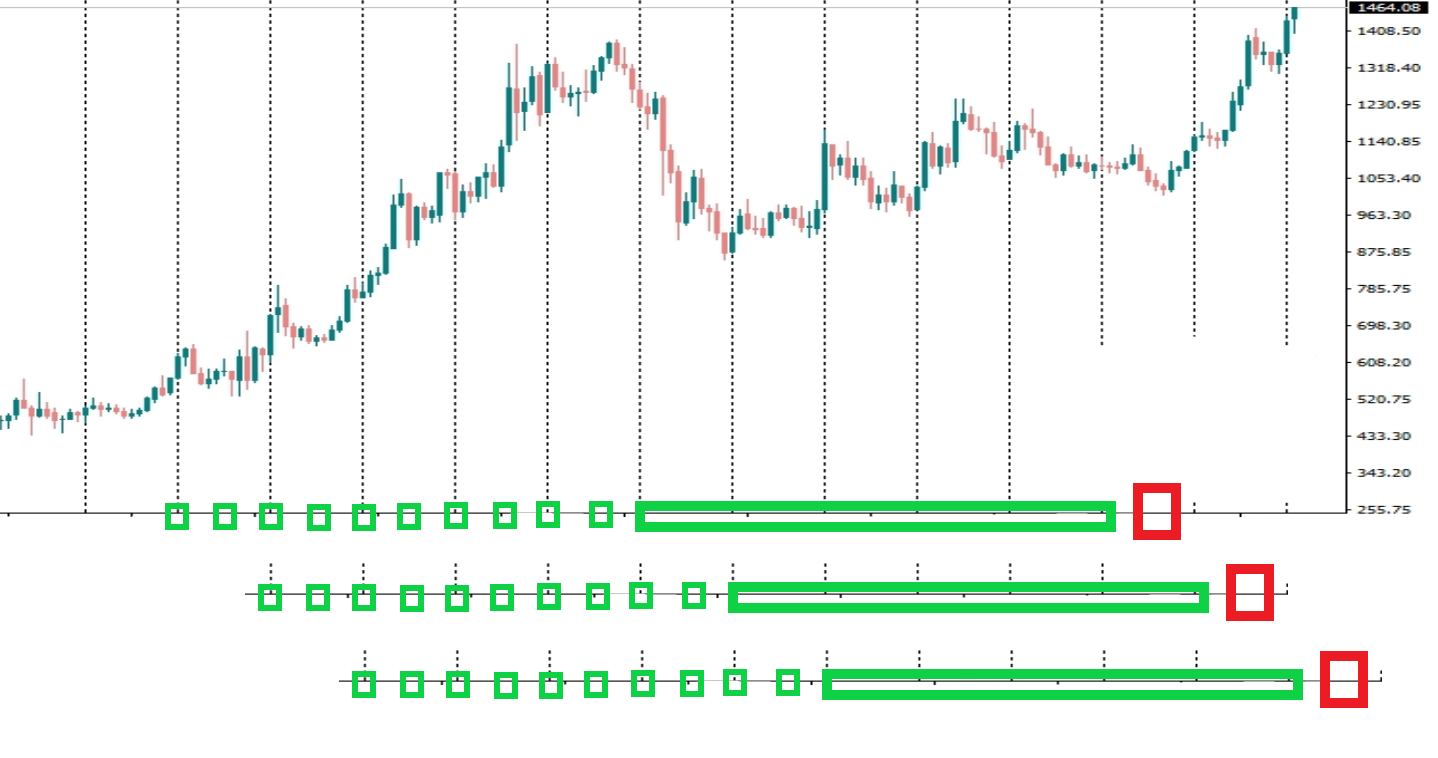

## Подготовка

In [ ]:
# Работа с массивами
# Загрузка датасетов из облака google
import gdown
# Отрисовка графиков
import matplotlib.pyplot as plt
import numpy as np
# Работа с таблицами
import pandas as pd
# Нормировщики
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Основные слои
from tensorflow.keras.layers import ( Concatenate,
                                     Conv1D, Dense, Flatten, Input,
                                    )
# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Model, Sequential
# Оптимизаторы
from tensorflow.keras.optimizers import Adam
# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings

from pylab import rcParams

warnings.filterwarnings('ignore')



Настройка параметров графиков

Устанавливаются стандартные параметры для всех графиков:
- Стиль 'ggplot' для профессионального вида
- Размер фигур по умолчанию 14x7 дюймов

In [4]:
# Назначение размера и стиля графиков по умолчанию

plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

Скачивание датасетов с курсами акций Лукойла за 2016-2017 и 2018-2019 годы.


In [5]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

Загрузка и предварительная обработка данных

1. Загрузка CSV-файлов с удалением столбцов DATE и TIME (не используются в модели)
2. Объединение данных за разные годы в один DataFrame
3. Проверка размерности данных и вывод списка столбцов

In [6]:
# Загрузка и предварительная обработка
data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

print(data16_17.shape)
print(data18_19.shape)

# Объединение датасетов
data = pd.concat([data16_17, data18_19]).reset_index(drop=True)

# Проверка формы данных
print(data.shape)

# Выводим названия столбцов
col = data.columns
print(col)

(263925, 5)
(217947, 5)
(481872, 5)
Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


Подготовка признаков

1. Выбираем только базовые признаки: OPEN, MAX, MIN, CLOSE, VOLUME
2. Добавляем производные признаки:
   - Первые разности (первые производные)
   - Вторые разности (вторые производные)
3. Удаляем строки с пропусками (NaN), которые появились при вычислении разностей
4. Преобразуем данные в numpy array для дальнейшей обработки

In [7]:
# Выбор только нужных базовых признаков
base_cols = ['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME']
data = data[base_cols].astype(np.float32)

# Добавим только простые производные (1-я и 2-я)
for col in base_cols:
    data[f'd_{col}'] = data[col].diff()
    data[f'd2_{col}'] = data[col].diff().diff()

# Удаление пропусков
data = data.dropna().reset_index(drop=True)

# Преобразование в массив
values = data.values.astype(np.float32)

Нормализация данных

1. Разделение данных на признаки (X) и целевую переменную (y - цена закрытия)
2. Нормализация данных с использованием MinMaxScaler:
   - X_scaler - для признаков
   - y_scaler - для целевой переменной
3. Определение параметров последовательностей:
   - SEQ_SHORT - длина короткой последовательности (50 точек)
   - SEQ_LONG - длина длинной последовательности (50 точек с шагом 10)

In [8]:
# Нормализация
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

close_idx = base_cols.index('CLOSE')
X = np.hstack((values[:, :close_idx], values[:, close_idx+1:]))
y = values[:, close_idx:close_idx+1]

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Последовательности
SEQ_SHORT, SEQ_LONG = 50, 50

Создание последовательностей для обучения

Функция make_seq создает последовательности заданной длины и шага:
- data - входные данные
- steps - количество шагов в последовательности
- step_size - шаг между точками в последовательности

Создаются два набора последовательностей:
1. X1 - короткие последовательности (50 точек с шагом 1)
2. X2 - длинные последовательности (50 точек с шагом 10)
3. y_seq - соответствующие целевые значения

Все последовательности обрезаются до одинаковой длины для согласованности.

In [9]:
def make_seq(data, steps, step_size):
    res = []
    for i in range(steps * step_size, len(data)):
        idx = [i - j * step_size for j in range(steps)][::-1]
        res.append(data[idx])
    return np.array(res, dtype=np.float32)

X1 = make_seq(X_scaled, SEQ_SHORT, 1)
X2 = make_seq(X_scaled, SEQ_LONG, 10)
y_seq = y_scaled[SEQ_SHORT * 10:]

min_len = min(len(X1), len(X2), len(y_seq))
X1, X2, y_seq = X1[-min_len:], X2[-min_len:], y_seq[-min_len:]

Построение модели нейронной сети

Архитектура модели:
1. Два входных слоя для коротких и длинных последовательностей
2. Сверточные слои (Conv1D) для извлечения признаков из каждой последовательности
3. Объединение признаков через Concatenate
4. Полносвязные слои (Dense) для регрессии
5. Выходной слой с одним нейроном (предсказание цены)

Модель компилируется с оптимизатором Adam и функцией потерь MSE.

In [10]:
# Создание модели
inp1 = Input(shape=(SEQ_SHORT, X1.shape[2]))
inp2 = Input(shape=(SEQ_LONG, X2.shape[2]))
x1 = Conv1D(16, 3, activation='relu')(inp1)
x2 = Conv1D(16, 3, activation='relu')(inp2)
x1 = Flatten()(x1)
x2 = Flatten()(x2)
x = Concatenate()([x1, x2])
x = Dense(64, activation='relu')(x)
out = Dense(1)(x)

model = Model([inp1, inp2], out)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Обучение
history = model.fit(
    [X1, X2], y_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 16)    │        688 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 48, 16)    │        688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 768)       │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1536)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     98,368 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,809 (389.88 KB)

 Trainable params: 99,809 (389.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.0014 - val_loss: 3.3788e-06
Epoch 2/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 5.4435e-06 - val_loss: 7.9038e-06
Epoch 3/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 4.2468e-06 - val_loss: 6.1312e-06
Epoch 4/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 3.7585e-06 - val_loss: 4.3324e-06
Epoch 5/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 3.4478e-06 - val_loss: 1.9659e-06
Epoch 6/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 2.8897e-06 - val_loss: 3.5242e-06
Epoch 7/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 2.8557e-06 - val_loss: 1.3463e-06
Epoch 8/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 2.5492e-06 - val_loss: 8.0974e-06
Epoch 9/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 2.3346e-06 - val_loss: 1.2264e-06
Epoch 10/10
13539/13539 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 2.1983e-06 - val_loss: 1.7770e-06


Вспомогательные функции для визуализации

1. plot_learning_curve - отображает график обучения (loss и val_loss)
2. eval_net - оценивает качество модели:
   - Сравнение предсказаний с реальными значениями
   - Анализ корреляции ошибок по лагам
   - График автокорреляции

In [11]:
def plot_learning_curve(history, title='График процесса обучения'):

    plt.figure(figsize=(14, 6))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Ошибка на валидации', color='orange')
    plt.title(title)
    plt.xlabel('Эпоха')
    plt.ylabel('Среднеквадратичная ошибка (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def eval_net(model, X1, X2, y_scaled, y_scaler, lags=50):
    """
    Оценка модели:
    - График предсказания vs факт
    - График корреляции ошибок по лагам
    """
    # Предсказания
    y_pred_scaled = model.predict([X1, X2], verbose=0)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_scaled)

    # График фактических vs прогнозных
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label='Факт', color='blue')
    plt.plot(y_pred, label='Прогноз', color='red', alpha=0.7)
    plt.title('Фактические и прогнозные значения')
    plt.xlabel('Временной шаг')
    plt.ylabel('CLOSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # График корреляции 
    def correlate(a, b):
        return np.corrcoef(a, b)[0, 1]

    steps = range(1, min(lags + 1, len(y_true) // 2))
    cross_corr = [correlate(y_true[:-s, 0], y_pred[s:, 0]) for s in steps]
    auto_corr = [correlate(y_true[:-s, 0], y_true[s:, 0]) for s in steps]

    plt.figure(figsize=(14, 6))
    plt.plot(steps, cross_corr, label='Прогноз vs Факт')
    plt.plot(steps, auto_corr, label='Автокорреляция факта')
    plt.title('Корреляция предсказаний и факта с лагами')
    plt.xlabel('Лаг')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.grid(True)
    plt.show()

Оценка результатов

1. Отображение графика процесса обучения
2. Оценка качества модели на тестовых данных

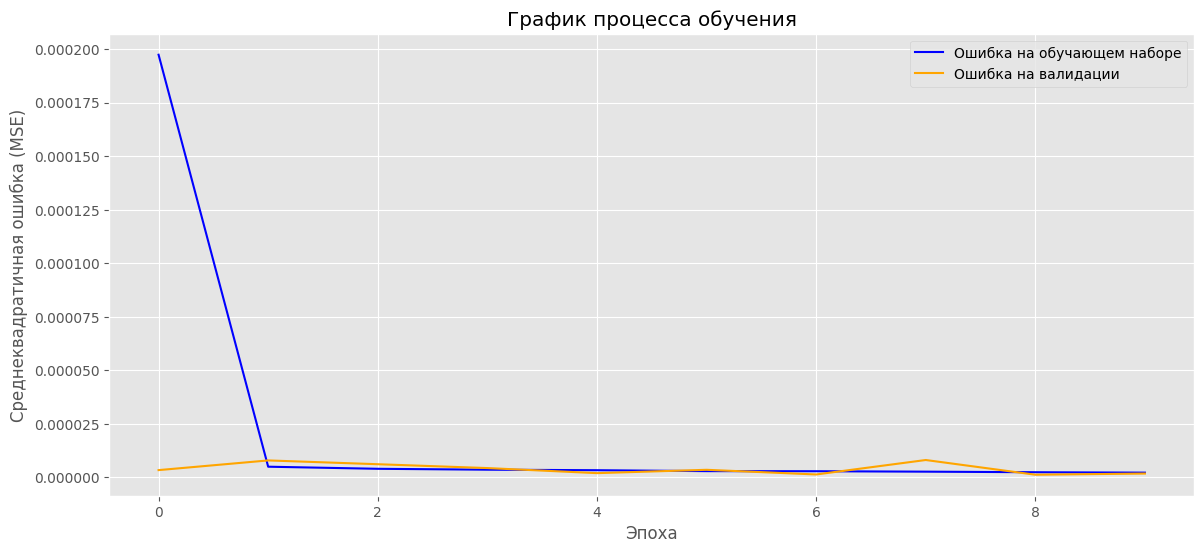

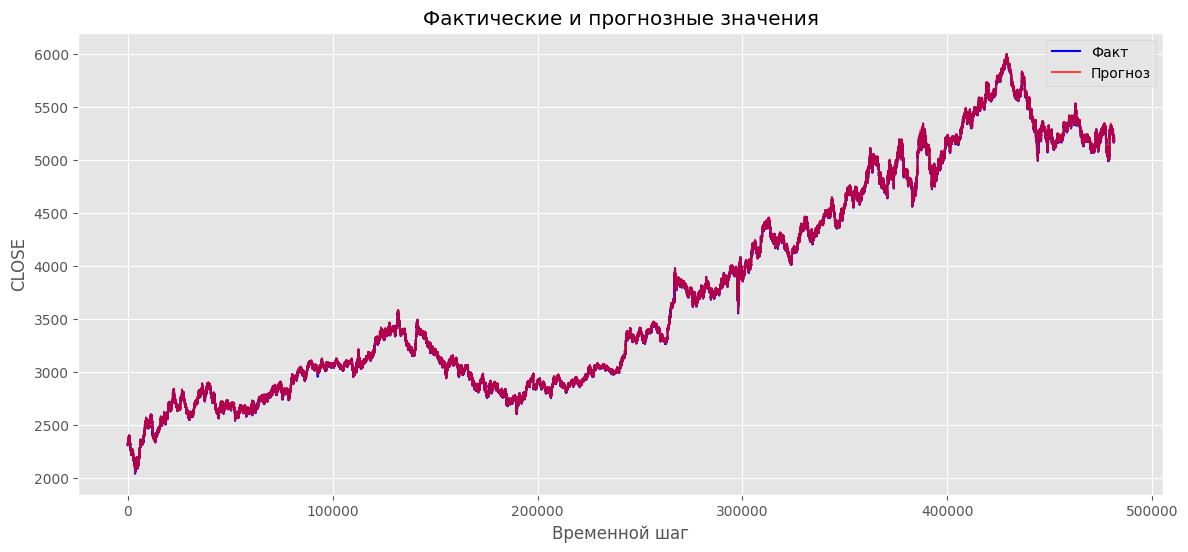

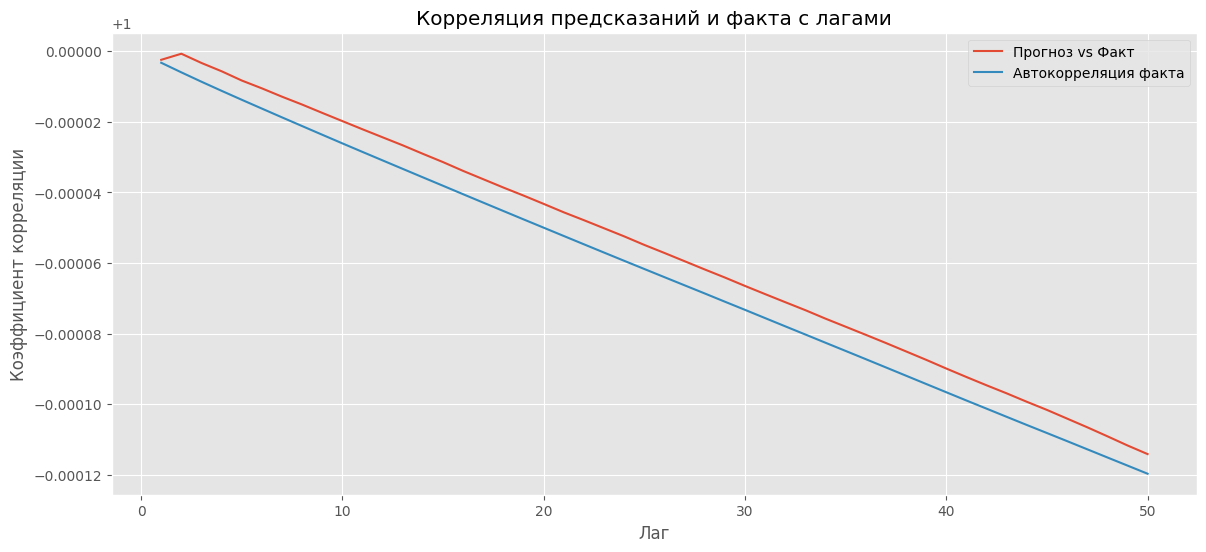

In [12]:
# График обучения
plot_learning_curve(history)
#Реальные и прогнозируемые значения
eval_net(model, X1, X2, y_seq, y_scaler)